In [ ]:
%matplotlib inline

In [ ]:
from datetime import datetime

import backtrader as bt  # 升级到最新版
import matplotlib.pyplot as plt  # 由于 Backtrader 的问题，此处要求 pip install matplotlib==3.2.2
import akshare as ak  # 升级到最新版
import pandas as pd

# plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

# 利用 AKShare 获取股票的后复权数据，这里只获取前 7 列
stock_hfq_df = ak.stock_zh_a_hist(symbol="000001", adjust="hfq").iloc[:, :7]
# 删除 `股票代码` 列
del stock_hfq_df['股票代码']
# 处理字段命名，以符合 Backtrader 的要求
stock_hfq_df.columns = [
    'date',
    'open',
    'close',
    'high',
    'low',
    'volume',
]
# 把 date 作为日期索引，以符合 Backtrader 的要求
stock_hfq_df.index = pd.to_datetime(stock_hfq_df['date'])


class MyStrategy(bt.Strategy):
    """
    主策略程序
    """
    params = (("maperiod", 20),)  # 全局设定交易策略的参数

    def __init__(self):
        """
        初始化函数
        """
        self.data_close = self.datas[0].close  # 指定价格序列
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buy_price = None
        self.buy_comm = None
        # 添加移动均线指标
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod
        )

    def next(self):
        """
        执行逻辑
        """
        if self.order:  # 检查是否有指令等待执行,
            return
        # 检查是否持仓
        if not self.position:  # 没有持仓
            if self.data_close[0] > self.sma[0]:  # 执行买入条件判断：收盘价格上涨突破20日均线
                self.order = self.buy(size=100)  # 执行买入
        else:
            if self.data_close[0] < self.sma[0]:  # 执行卖出条件判断：收盘价格跌破20日均线
                self.order = self.sell(size=100)  # 执行卖出


初始资金: 1000000
回测期间：19910403:20200616
总资金: 1217360.83
净收益: 217360.83


<IPython.core.display.Javascript object>

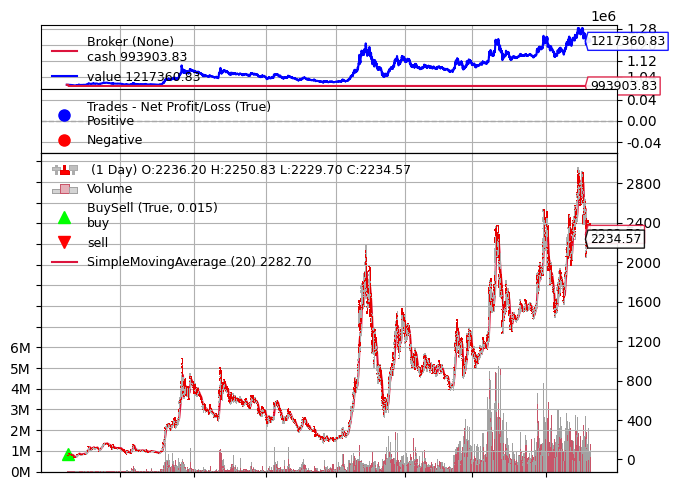

In [ ]:


cerebro = bt.Cerebro()  # 初始化回测系统
start_date = datetime(1991, 4, 3)  # 回测开始时间
end_date = datetime(2020, 6, 16)  # 回测结束时间
data = bt.feeds.PandasData(dataname=stock_hfq_df, fromdate=start_date, todate=end_date)  # 加载数据
cerebro.adddata(data)  # 将数据传入回测系统
cerebro.addstrategy(MyStrategy)  # 将交易策略加载到回测系统中
start_cash = 1000000
cerebro.broker.setcash(start_cash)  # 设置初始资本为 100000
cerebro.broker.setcommission(commission=0.002)  # 设置交易手续费为 0.2%
cerebro.run()  # 运行回测系统

port_value = cerebro.broker.getvalue()  # 获取回测结束后的总资金
pnl = port_value - start_cash  # 盈亏统计

print(f"初始资金: {start_cash}\n回测期间：{start_date.strftime('%Y%m%d')}:{end_date.strftime('%Y%m%d')}")
print(f"总资金: {round(port_value, 2)}")
print(f"净收益: {round(pnl, 2)}")

cerebro.plot(style='candlestick')[0][0]  # 画图
